# Collaborative Filtering

In [1]:
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm

Load the raw data

In [2]:
df = pd.read_csv("data/raw_data.csv")
print(f"We have a dataset of {len(df)} entries")

We have a dataset of 67503 entries


We want to build a matrix where each row is a playlist, and each column resembles a song. The dimensions of our matrix resemble those of the playlist number and track number.

In [3]:
num_playlists = df["name"].nunique()  # count distinct values, this is the number of playlists
num_tracks = df["track_name"].nunique()  # count distinct values, this is the number of tracks
print(f"Playlists: {num_playlists} \nTracks: {num_tracks}")

Playlists: 869 
Tracks: 30049


Group the data by the playlist name. This results in a Series.

In [4]:
playlists = df.groupby('name')["track_name"].apply(list)
playlists.head()

name
 CHiLl         [Make Me (Cry), Party Monster, Don't Wanna Kno...
 Frozen        [Frozen Heart, Do You Want to Build a Snowman?...
 indie rock    [Be Good (RAC Remix), Bambi, Your English Is G...
#Relaxed       [All That I Can Say, Reminisce, Butterfly, Cha...
#Workout       [Can't Feel My Face - Martin Garrix Remix, Ign...
Name: track_name, dtype: object

We need a list of the unique songs to create each playlist vector.

In [5]:
unique_songs = list(df["track_name"].unique())
unique_songs

['Lose Control (feat. Ciara & Fat Man Scoop)',
 'Toxic',
 'Crazy In Love',
 'Rock Your Body',
 "It Wasn't Me",
 'Yeah!',
 'My Boo',
 'Buttons',
 'Say My Name',
 'Hey Ya! - Radio Mix / Club Mix',
 'Promiscuous',
 'Right Where You Want Me - Radio Edit Version',
 'Beautiful Soul',
 "Leavin'",
 'Me & U',
 'Ice Box',
 'Sk8er Boi',
 'Run It!',
 'Check On It - feat. Bun B and Slim Thug',
 "Jumpin', Jumpin'",
 'Soak Up The Sun',
 'Where Is The Love?',
 "Stacy's Mom",
 'Just The Girl',
 'Yo (Excuse Me Miss)',
 'Year 3000',
 'Lip Gloss',
 'Everytime We Touch - Radio Edit',
 'Whatcha Say',
 'Miss Independent',
 'Party In The U.S.A.',
 'The Great Escape',
 'Replay',
 'Forever',
 'Your Love Is My Drug',
 'Closer',
 'One Less Lonely Girl',
 'Paper Planes',
 'Mr. Brightside',
 'All The Small Things',
 'Beep',
 'Somebody To Love',
 'Dirty Little Secret',
 'Baby',
 'A Thousand Miles',
 'Livin on Sunday',
 'See You Again',
 'How Do You Sleep? - Featuring Ludacris',
 'This Is Me',
 'My Happy Ending',
 'C

We can now iteratively build our matrix by creating each playlist in a vector of its songs. This is done by one-hot encoding. 

In [6]:
one_hot_playlists = list()
for playlist in playlists:
    playlist_array = np.zeros(num_tracks)
    for song in playlist:
        playlist_array[unique_songs.index(song)] = 1  # set array to 1 at index of the song
    one_hot_playlists.append(playlist_array)
one_hot_playlists = np.array(one_hot_playlists)  # convert to one numpy array (matrix)

For example, the first playlist "CHiLl" includes the song "Make Me (Cry)" and does not include ". Check if the value is one and zero respectively at the corresponding positions.

In [7]:
print(one_hot_playlists[0][unique_songs.index("Make Me (Cry)")] == 1.0)
print(one_hot_playlists[0][unique_songs.index("Mr. Brightside")] == 0.0)

True
True


The shape of our playlists should be playlist number times distinct track number.

In [8]:
one_hot_playlists.shape

(869, 30049)

In [9]:
from scripts.matrix_factorization import MF

ImportError: cannot import name 'MF' from 'scripts.matrix_factorization' (C:\Users\marjaw\PycharmProjects\mms-project-23\recommender_model\scripts\matrix_factorization.py)

We now apply matrix factorization on our data. This means, we try to find two matrices, which multiplied are as close to the original matrix as possible. We train using gradient descent, meaning we try to minimize the error in each iteration.

In [ ]:
mf = MF(one_hot_playlists, K=2, alpha=0.1, beta=0.01, iterations=100)
mf.train()

As a result, we get a matrix where original values should be close to their original values, but unknown values, in our case songs that are not in the playlist, are approximated by the matrix factorization. For example, if we look at the same song from earlier, the value is close to 1. Looking in at a song that has not been added to the playlist, the value is now approximated to how likely it should be added to the playlist.

In [ ]:
print(mf.full_matrix()[0][unique_songs.index("Make Me (Cry)")])
print(mf.full_matrix()[0][unique_songs.index("Mr. Brightside")])

---> Epoch 0
ave mse 0.0 ===> Total training time: 0.504 seconds.
---> Epoch 1
ave mse 0.0 ===> Total training time: 2.054 seconds.
Convergence after 1 epochs time took: 2.054 seconds.


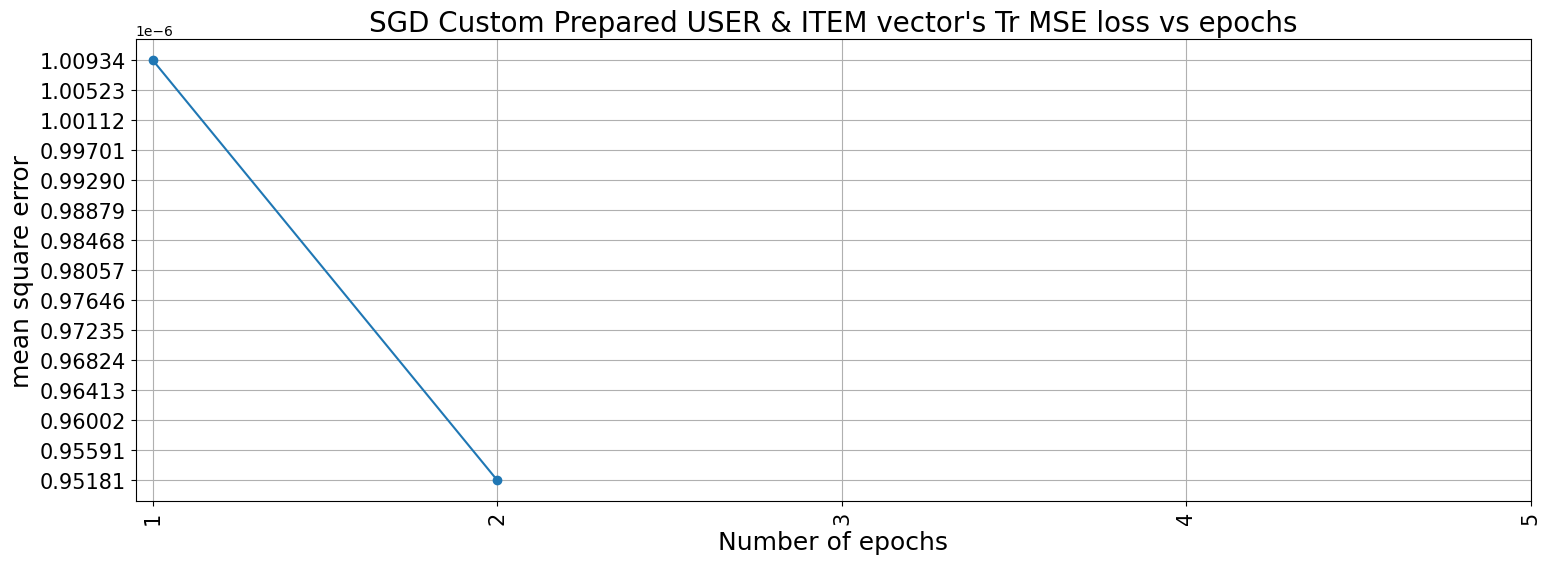

In [11]:
from scripts.matrix_factorization import MatrixFactorization
obj = MatrixFactorization(one_hot_playlists)
obj.fit()

In [15]:
obj

In [ ]:
mf.full_matrix()[0]

In [ ]:
mf.full_matrix()